# Data Preprocessing
## Clipping + linear Scaling

In [1]:
# For Development and debugging:
# Reload modul without restarting the kernel
#%load_ext autoreload
#%autoreload 2

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import multiprocessing
from multiprocessing import Pool
import socket
import sys
import time
import math

In [3]:
# Load external libraries
key = 'external_libs_path'
if socket.gethostname() == 'hughes-machine':
    external_libs_path = '/home/hhughes/Documents/Master_Thesis/Project/workspace/libs'
else:
    external_libs_path= '/storage/groups/ml01/code/andres.becker/master_thesis/workspace/libs'
print('External libs path: \n'+external_libs_path)

if not os.path.exists(external_libs_path):
    msg = 'External library path {} does not exist!'.format(external_libs_path)
    raise Exception(msg)

# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, external_libs_path)

#from test import plot_channel as plt_channel

External libs path: 
/home/hhughes/Documents/Master_Thesis/Project/workspace/libs


In [4]:
def load_channels(dataset_dir):
    temp_path = os.path.join(dataset_dir, 'channels.csv')
    channels_df = pd.read_csv(temp_path)
    input_channels = [
            "00_DAPI",
            "07_H2B",
            "01_CDK9_pT186",
            "03_CDK9",
            "05_GTF2B",
            "07_SETD1A",
            "08_H3K4me3",
            "09_SRRM2",
            "10_H3K27ac",
            "11_KPNA2_MAX",
            "12_RB1_pS807_S811",
            "13_PABPN1",
            "14_PCNA",
            "15_SON",
            "16_H3",
            "17_HDAC3",
            "19_KPNA1_MAX",
            "20_SP100",
            "21_NCL",
            "01_PABPC1",
            "02_CDK7",
            "03_RPS6",
            "05_Sm",
            "07_POLR2A",
            "09_CCNT1",
            "10_POL2RA_pS2",
            "11_PML",
            "12_YAP1",
            "13_POL2RA_pS5",
            "15_U2SNRNPB",
            "18_NONO",
            "20_ALYREF",
            "21_COIL"
        ]

    input_ids = channels_df.set_index('name').loc[input_channels].channel_id.sort_values().values
    
    return channels_df, input_ids

In [5]:
def get_train_ids(dataset_dir):
    # Load metadata file to get dataset splits
    temp_path = os.path.join(dataset_dir, 'filtered_metadata.csv')
    metadata_df = pd.read_csv(temp_path)
    train_mask = metadata_df.set == 'train'
    # load the ids corresponding to normal or DMSO and in the rain set
    #train_ids = set(metadata_df[train_mask].mapobject_id_cell.values.astype(str))
    train_ids = metadata_df[train_mask].mapobject_id_cell.values.astype(str)[0:10]


    # Now list files available in the file system
    data_dir = os.path.join(dataset_dir, 'data')
    file_ids = set([id.split(".")[0] for id in os.listdir(data_dir)])

    # check if all ids in the metadata file are available in the file system
    print('Are all train cell ids in the file system? ', set(train_ids).issubset(file_ids))
    
    return(train_ids)


In [6]:
def load_imgs_pixels(dataset_dir, input_ids):

    # get total number of pixels to allocate np array
    n_pixels_per_channel = 0
    for cell_id in train_ids:
        temp_path = os.path.join(dataset_dir, 'data', cell_id+'.npz')
        temp_cell = np.load(temp_path)
        n_pixels_per_channel += temp_cell['mask'].sum()

    # load pixel values
    imgs_pixels = np.zeros((n_pixels_per_channel, len(input_ids))).astype(np.uint16)
    low_idx = 0
    up_idx = 0
    for i, cell_id in enumerate(train_ids):

        if (i % 100) == 0:
            print('Loading cell {}/{}'.format(i+1, len(train_ids)))

        temp_path = os.path.join(dataset_dir, 'data', cell_id+'.npz')
        temp_cell = np.load(temp_path)
        temp_img = temp_cell['img'][:,:,input_ids].astype(np.uint16)
        temp_mask = temp_cell['mask']

        low_idx = up_idx
        up_idx += temp_mask.sum()
        imgs_pixels[low_idx:up_idx, :] = temp_img[temp_mask]
    
    return imgs_pixels


In [7]:
def plot_kde(data, label, ax):
    sns.kdeplot(data,
                shade=True,
                bw_method=0.2,
                label=label,
                ax=ax)
    
def plot_clipping_apporach(channel_pixels, threshold, app_name, axs):
    
    # Apply clipping
    channel_pixels[channel_pixels > threshold] = threshold
    # Plot clipping
    label = '{}={}'.format(app_name, str(round(threshold)))
    plot_kde(channel_pixels, label, axs[1])
    
    # Plot Clipping + Linear scaling
    label = app_name
    plot_kde(channel_pixels / threshold, label, axs[2])
    
    
def plot_orginial_channel_dist_vs_transform(channel_pixels, channel_name):
    n_columns = 3
    
    channel_pixels = channel_pixels.astype(np.float32)

    figsize = (n_columns * 7,7)
    fig, axs = plt.subplots(1,n_columns, figsize=figsize)

    # Set plots title
    axs[0].title.set_text('Original '+channel_name+' masked pixel dist')
    axs[1].title.set_text('Clipped data dist')
    axs[2].title.set_text('Clipping + Linear Scaling data dist')
    
    # plot original distribution
    plot_kde(channel_pixels, 'Unchanged dist', axs[0])

    # P_98 clipping----------------------------------------------------------
    p_98 = np.percentile(channel_pixels, 98, axis=0)
    app_name = 'P_98'
    plot_clipping_apporach(channel_pixels, p_98, app_name, axs)
    
    # P_99 clipping----------------------------------------------------------
    p_99 = np.percentile(channel_pixels, 99, axis=0)
    app_name = 'P_99'
    plot_clipping_apporach(channel_pixels, p_99, app_name, axs)
    
    # mean + 3*stddev clipping---------------------------------------------- 
    temp_slide = copy.deepcopy(channel_pixels)
    mean = temp_slide.mean()
    stddev = temp_slide.std()
    threshold = (mean + 3*stddev)
    app_name = 'mu+3sig'
    plot_clipping_apporach(channel_pixels, threshold, app_name, axs)

    # print axis legends
    for ax in axs:
        ax.legend()
    
    return fig

In [8]:
# load data and create jobs queue

dataset_dir = '/data/Master_Thesis_data/datasets/184A1_hannah_imgs_no_split'
    
channels_df, input_ids = load_channels(dataset_dir)
    
train_ids = get_train_ids(dataset_dir)
    
train_pixels = load_imgs_pixels(dataset_dir, input_ids)
    
n_workers = multiprocessing.cpu_count()
n_channels = len(input_ids)

# get channel names for plots
channel_names = [channels_df.set_index('channel_id').loc[c].values[0] for c in range(n_channels)]
channel_names = [channel_name.split("_")[1:] for channel_name in channel_names]
channel_names = ["_".join(channel_name) for channel_name in channel_names]
    
n_jobs = math.ceil(n_channels / n_workers)
jobs = {}
low_idx = 0
up_idx = 0
for i in range(n_jobs):
    low_idx = up_idx
    up_idx += n_workers
    if up_idx > n_channels: up_idx = n_channels
    temp_range = range(low_idx, up_idx)

    jobs[i] = [(train_pixels[:,c], channel_names[c]) for c in temp_range]
del(train_pixels)

Are all train cell ids in the file system?  True
Loading cell 1/10


In [9]:
jobs.keys()

dict_keys([0, 1, 2, 3, 4])

Starting job  0
Job completed in 0 mins
Starting job  1
Job completed in 0 mins
Starting job  2
Job completed in 0 mins
Starting job  3
Job completed in 0 mins
Starting job  4
Job completed in 0 mins


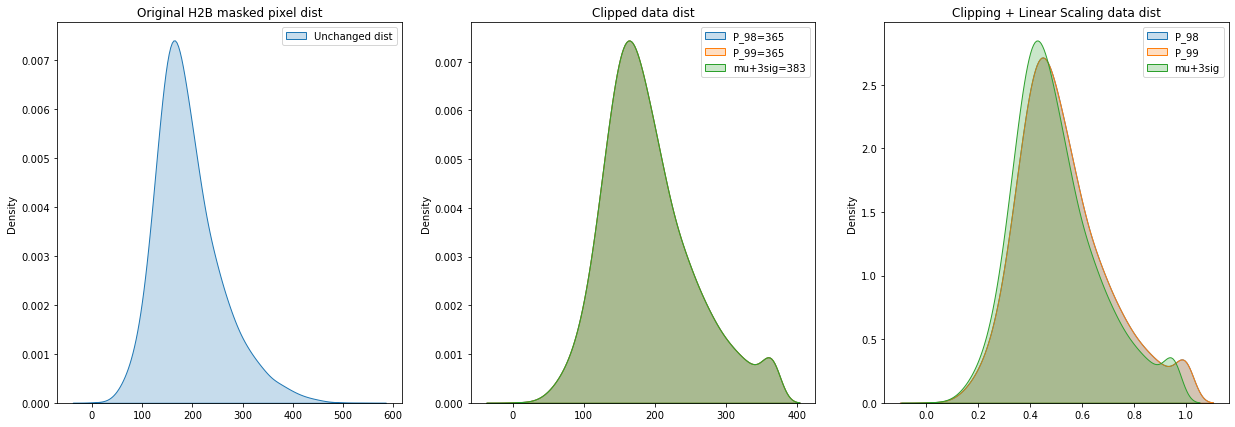

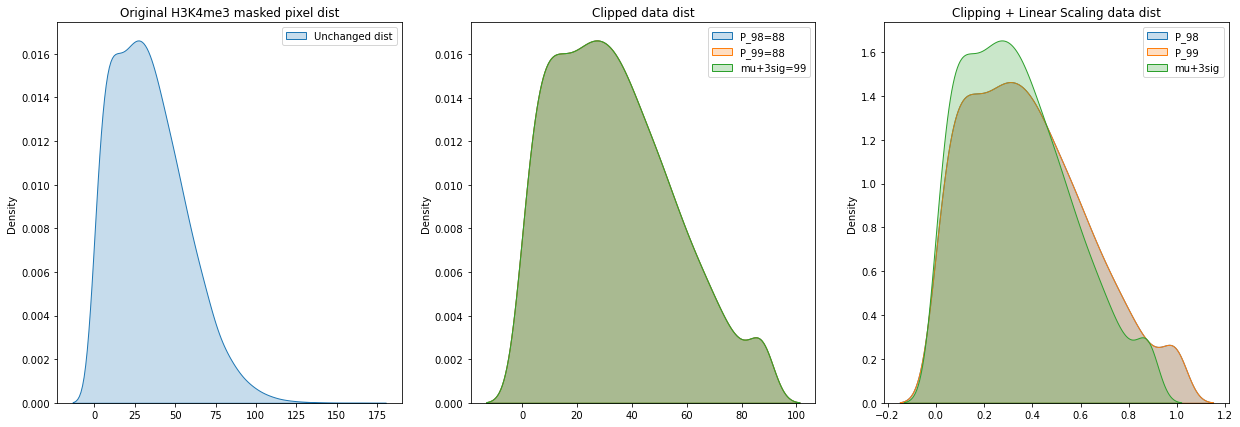

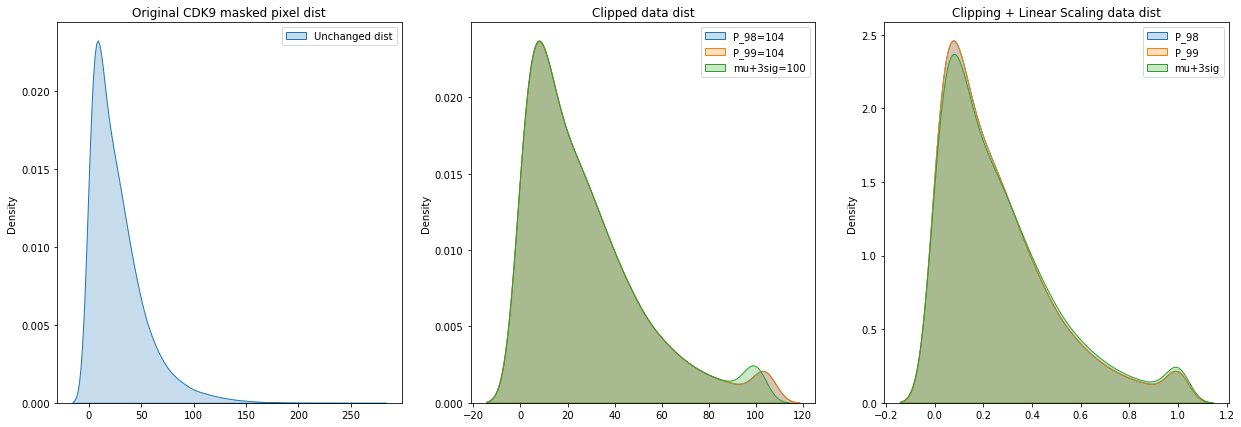

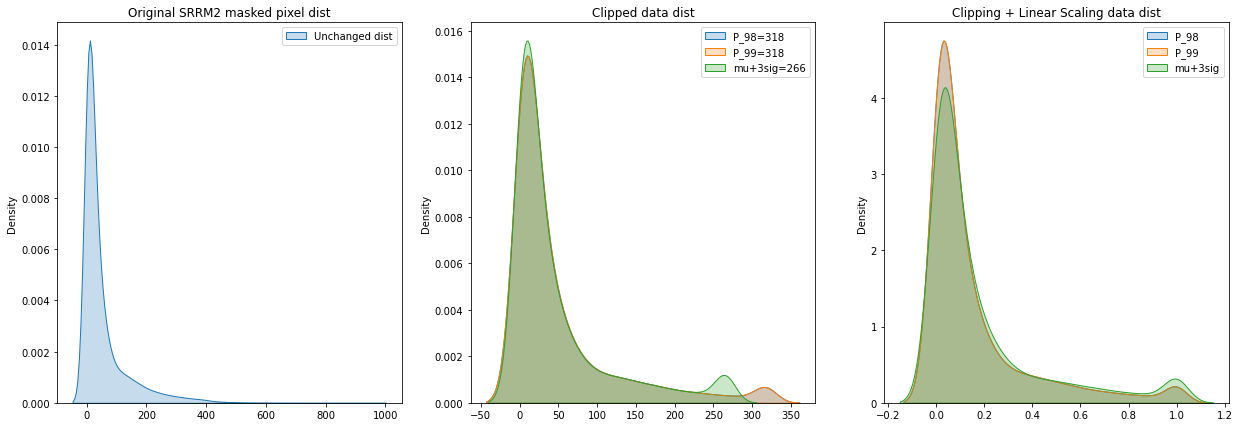

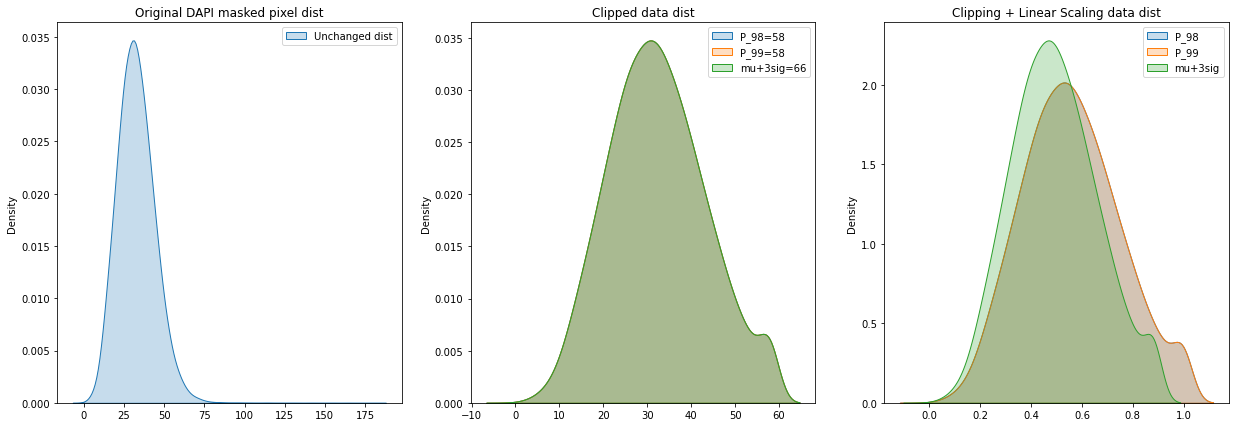

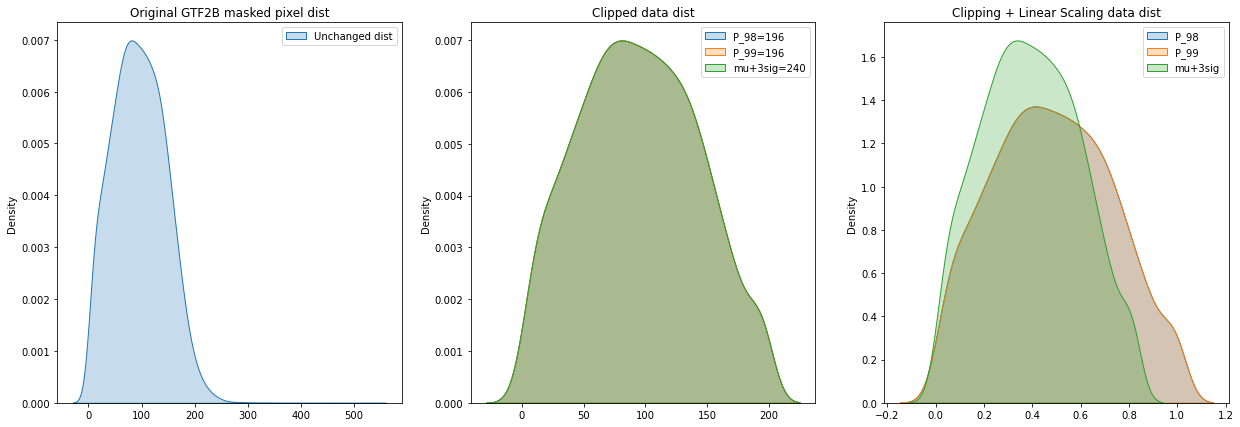

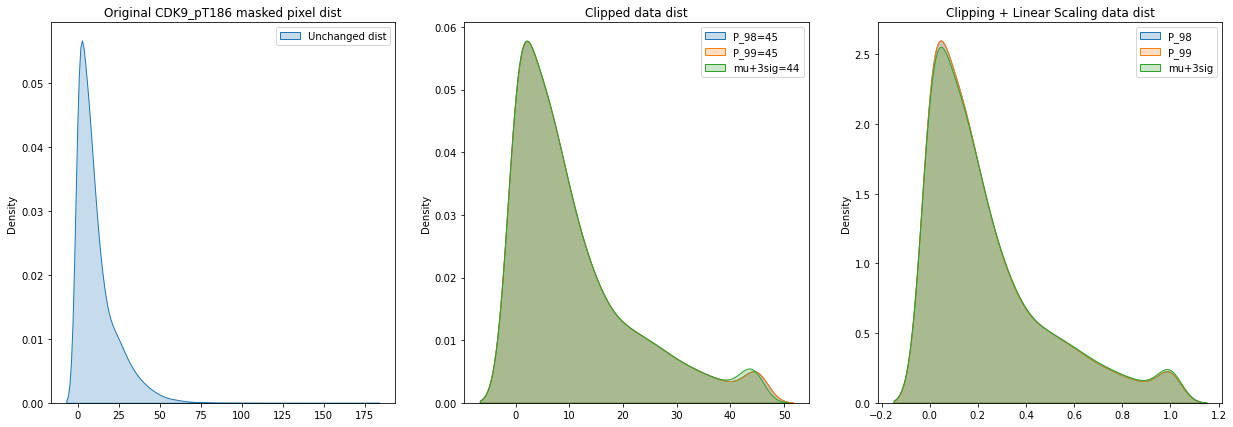

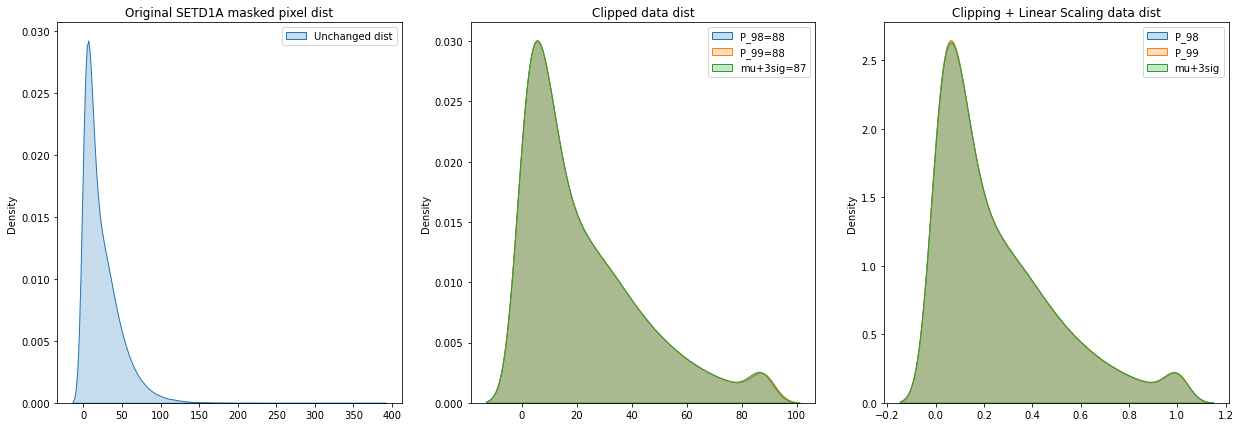

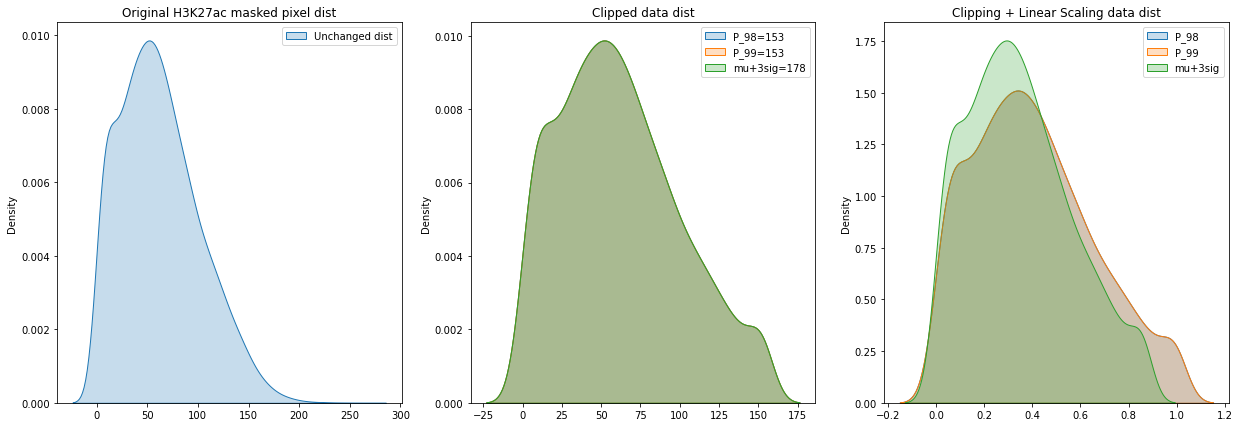

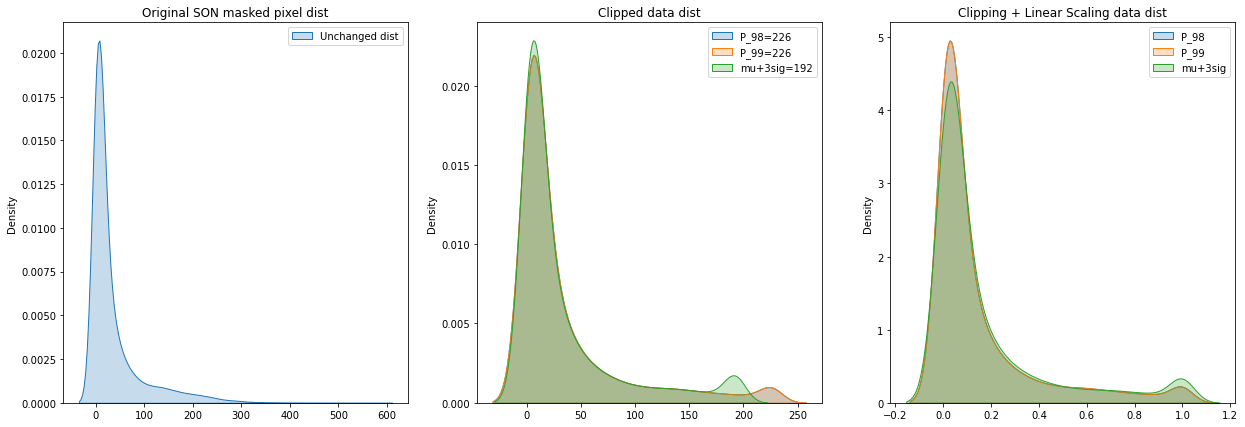

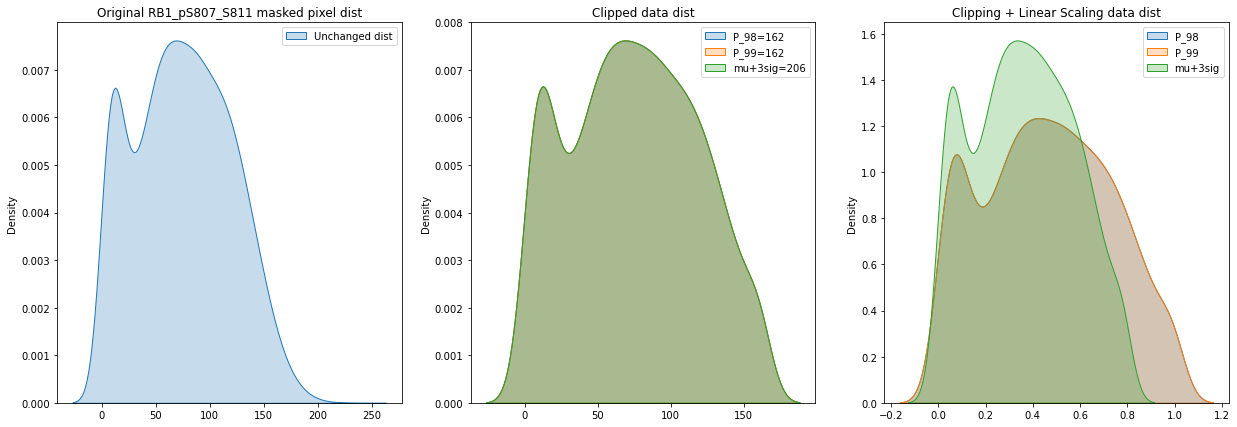

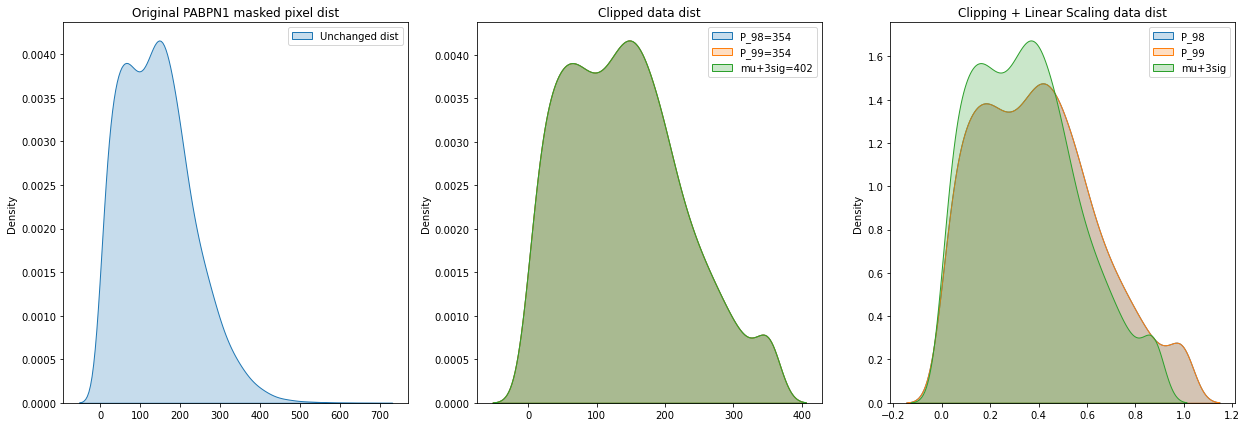

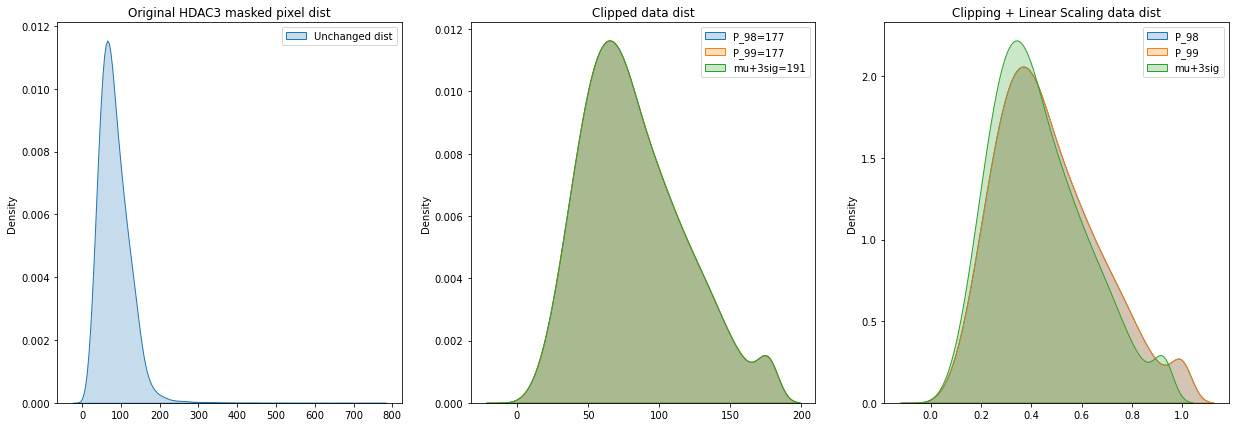

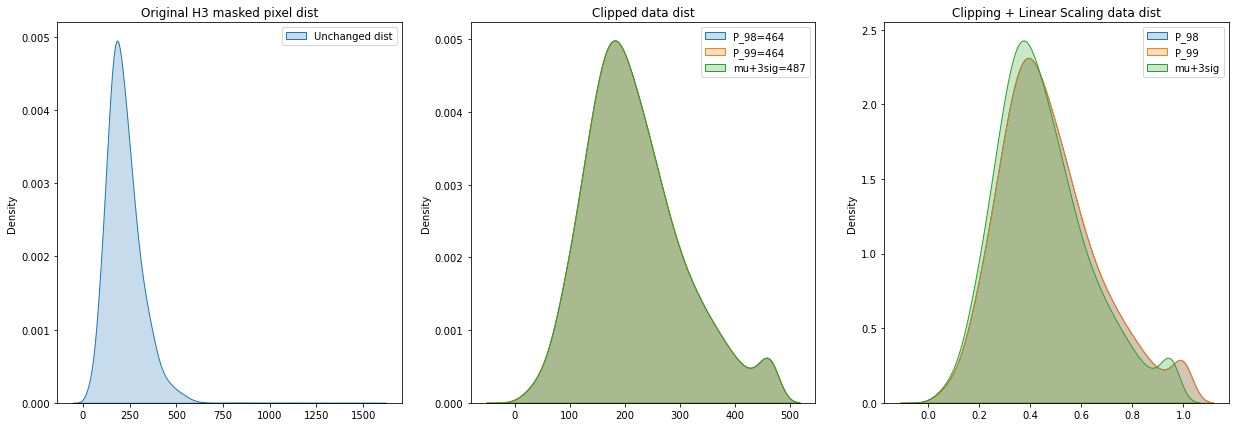

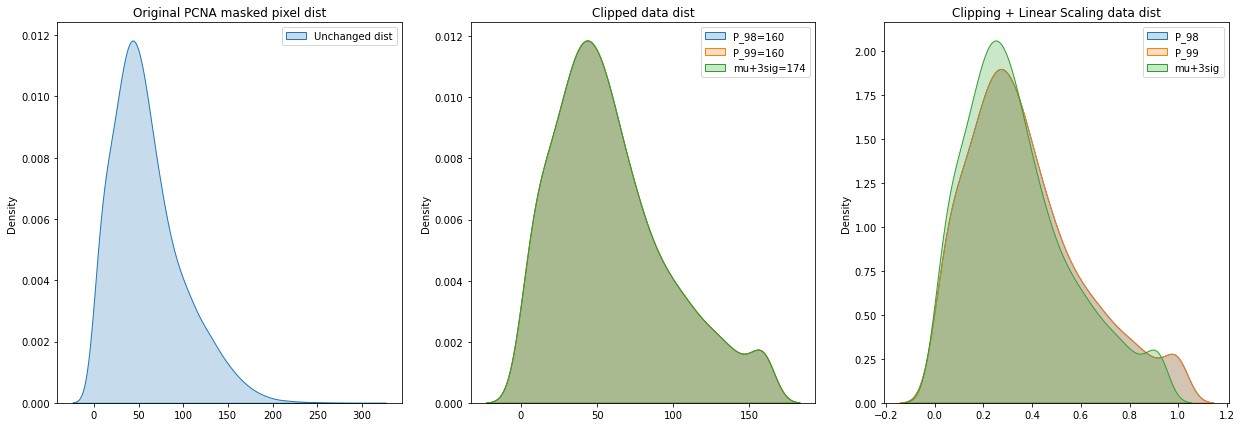

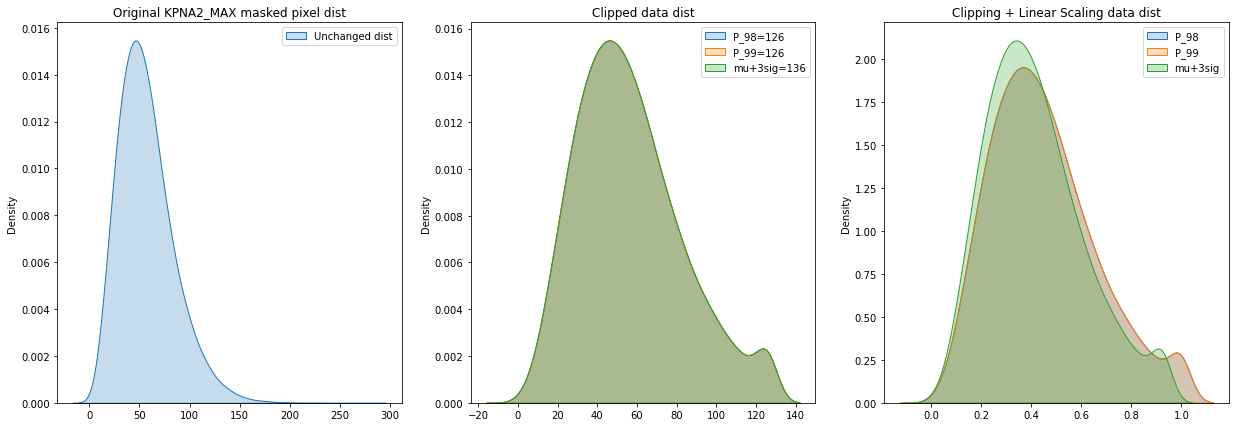

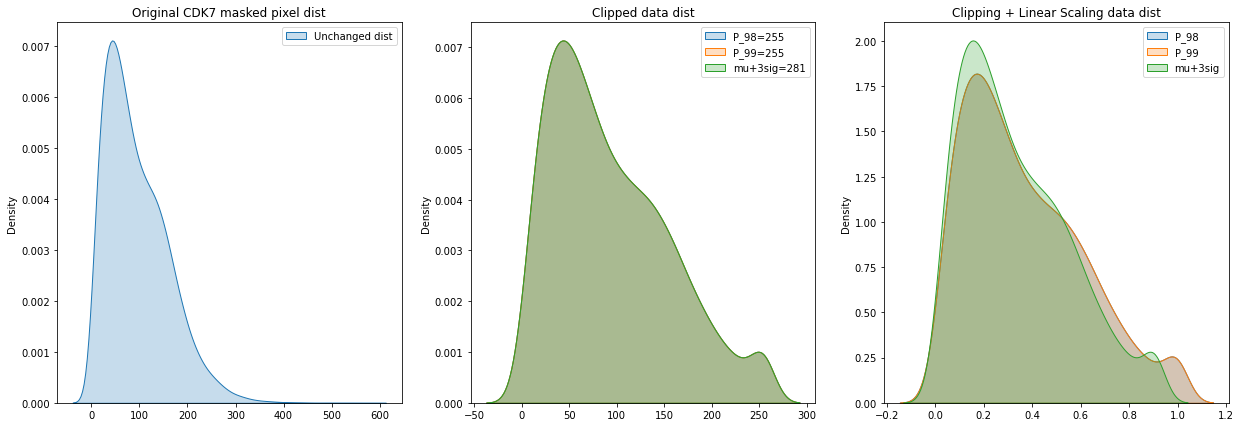

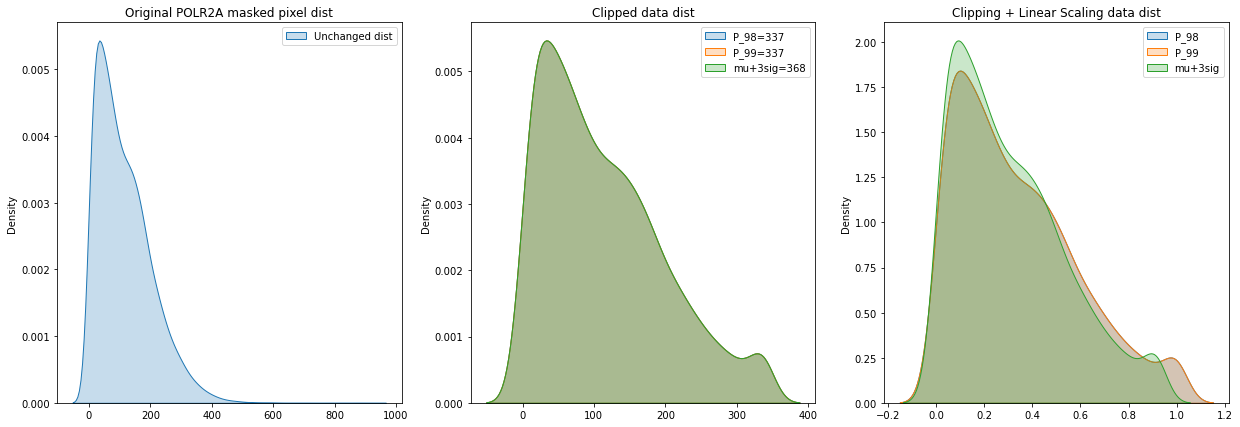

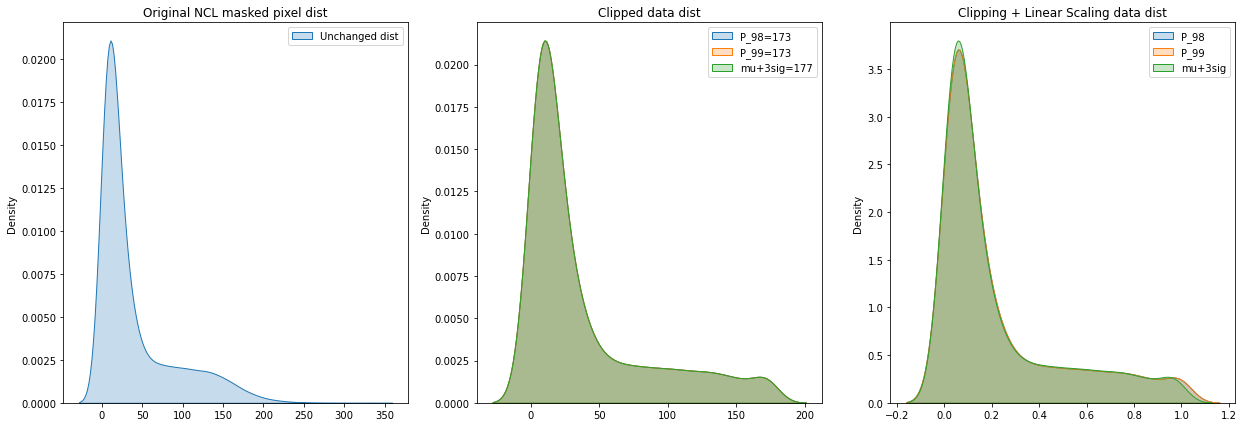

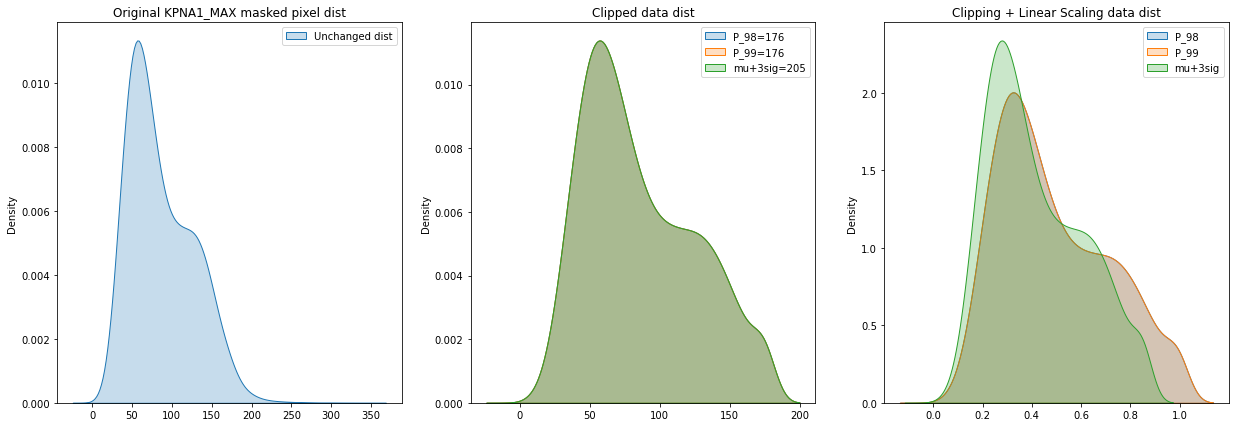

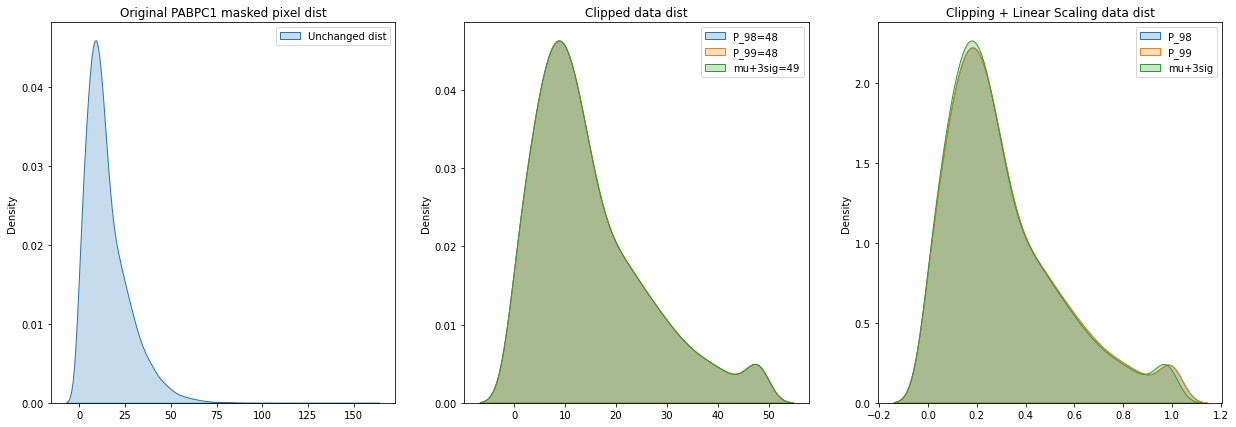

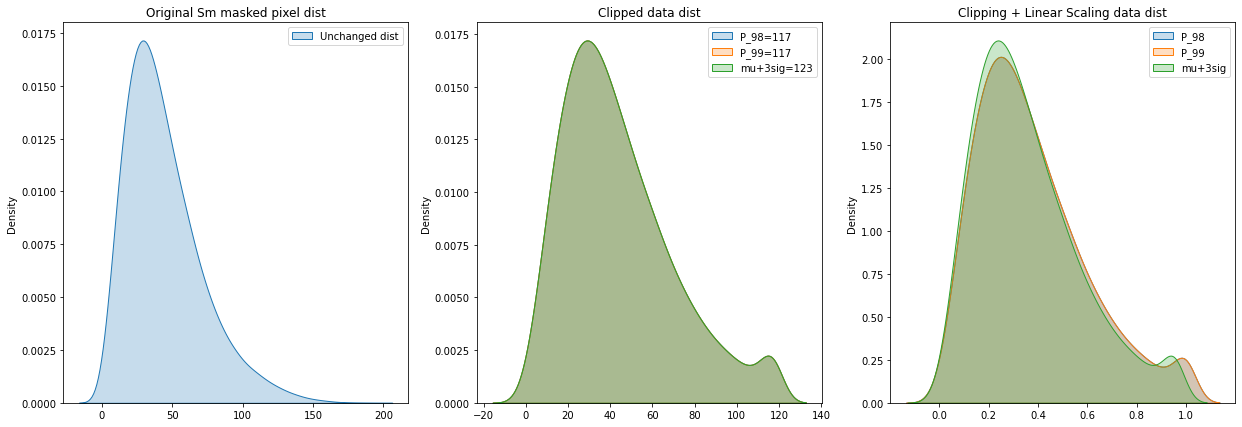

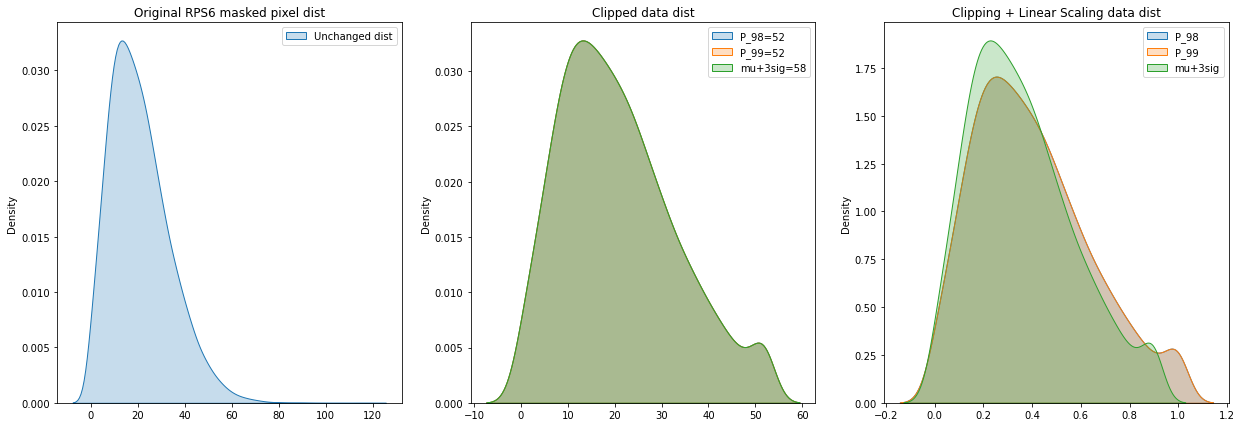

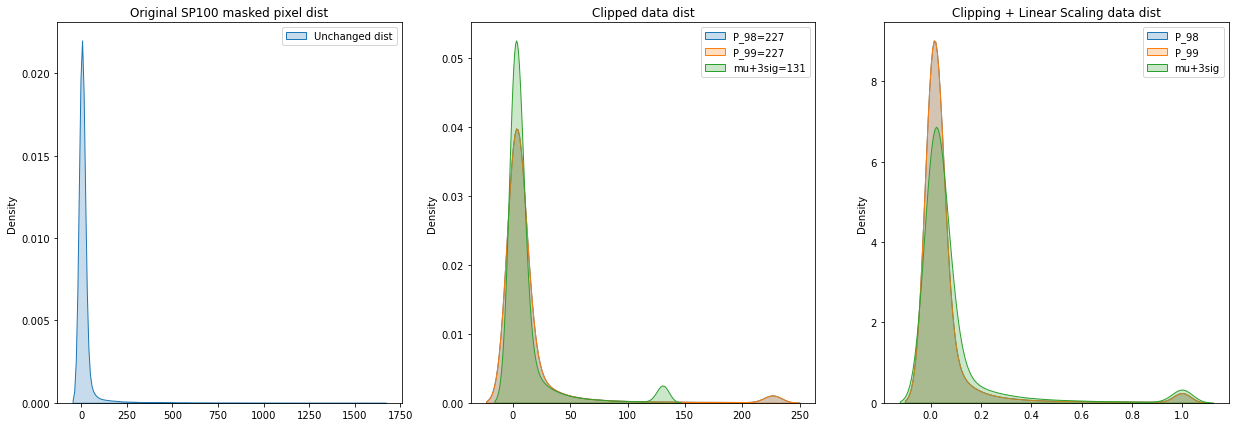

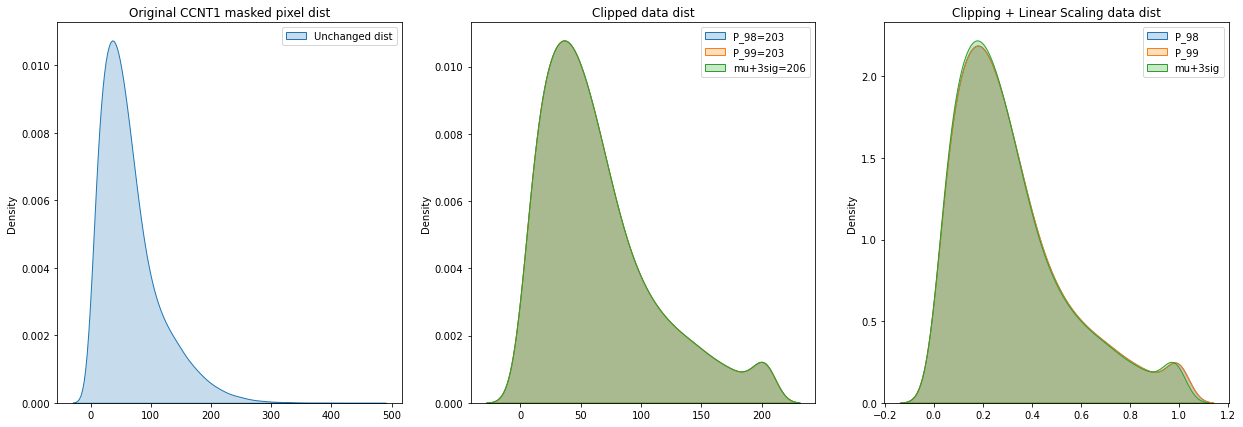

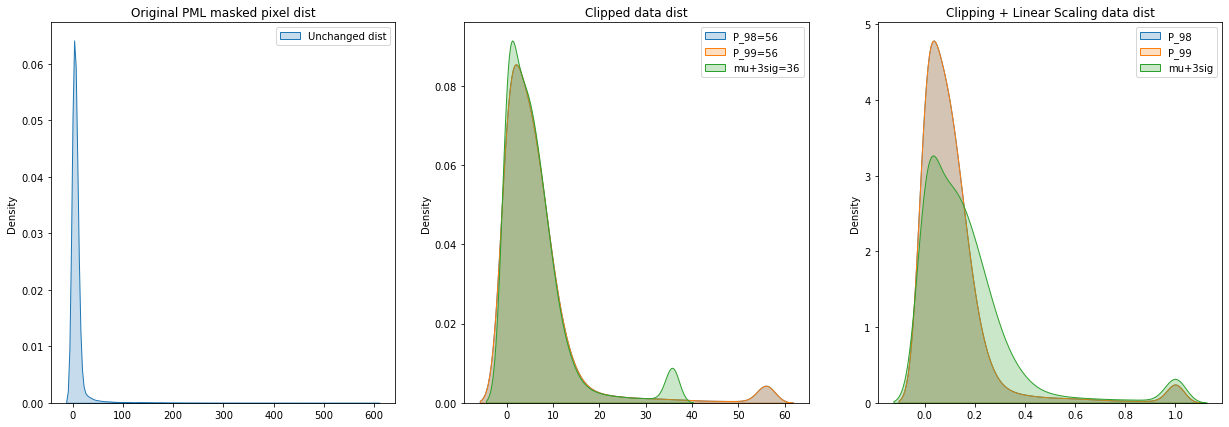

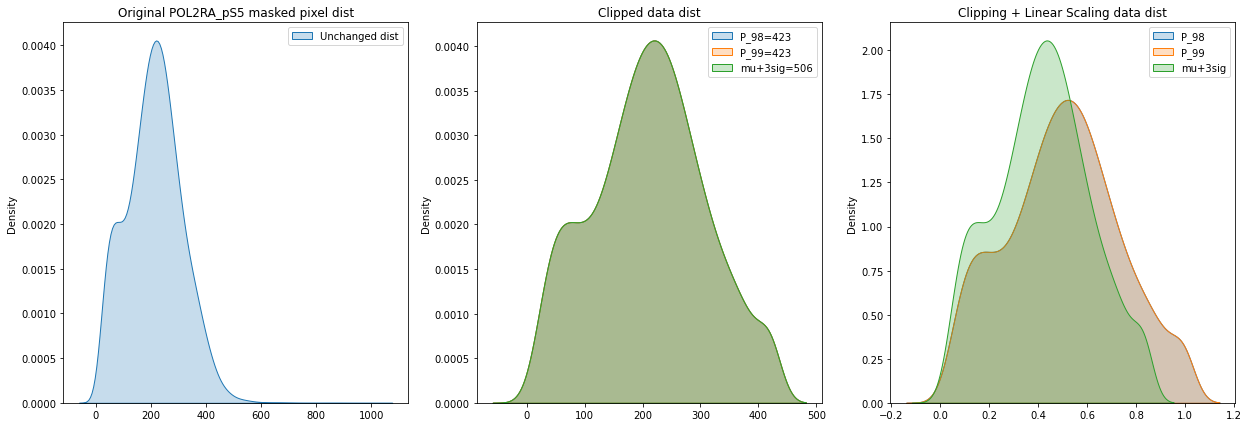

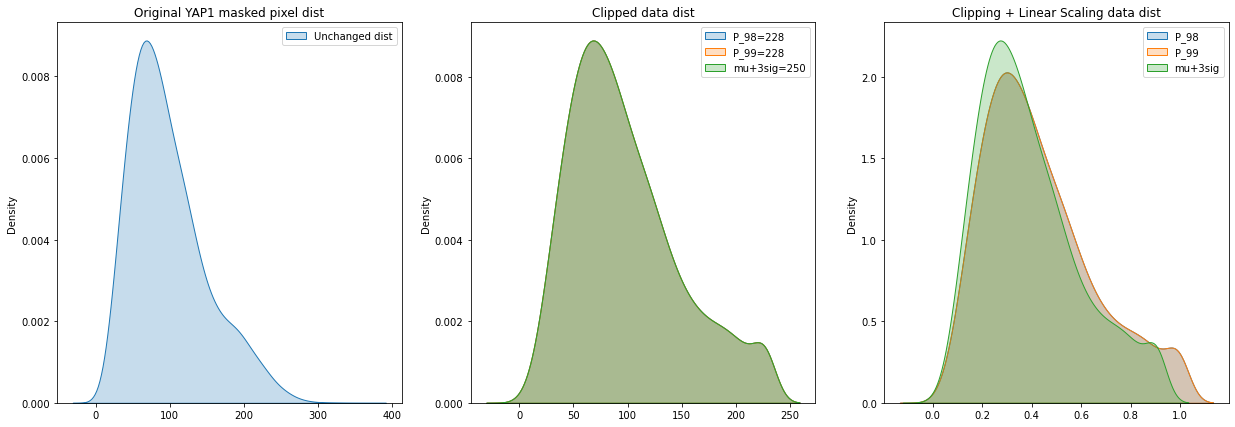

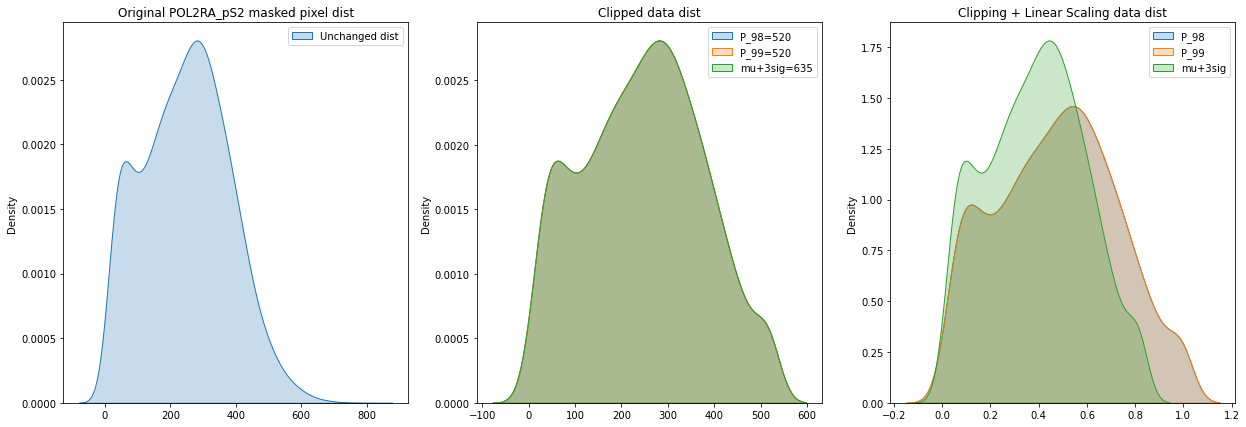

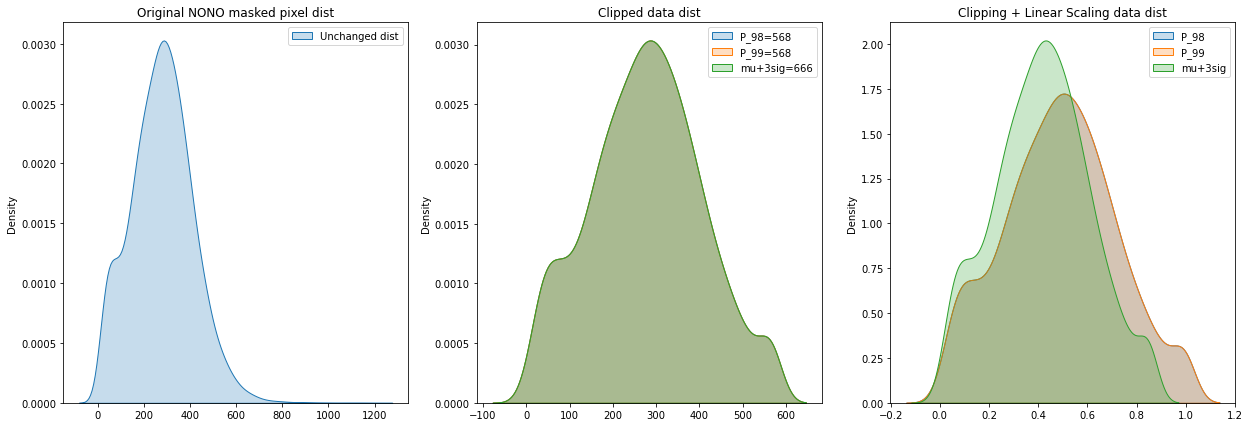

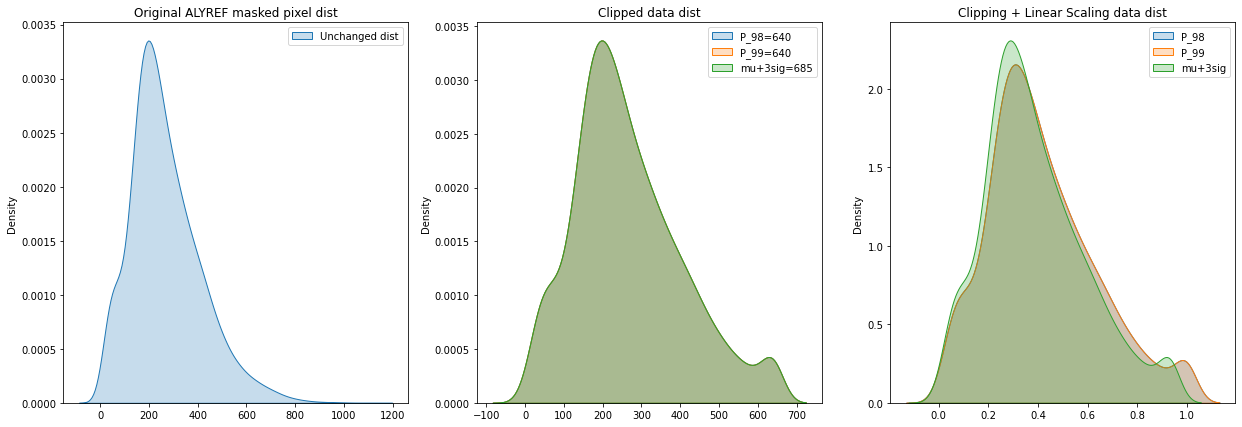

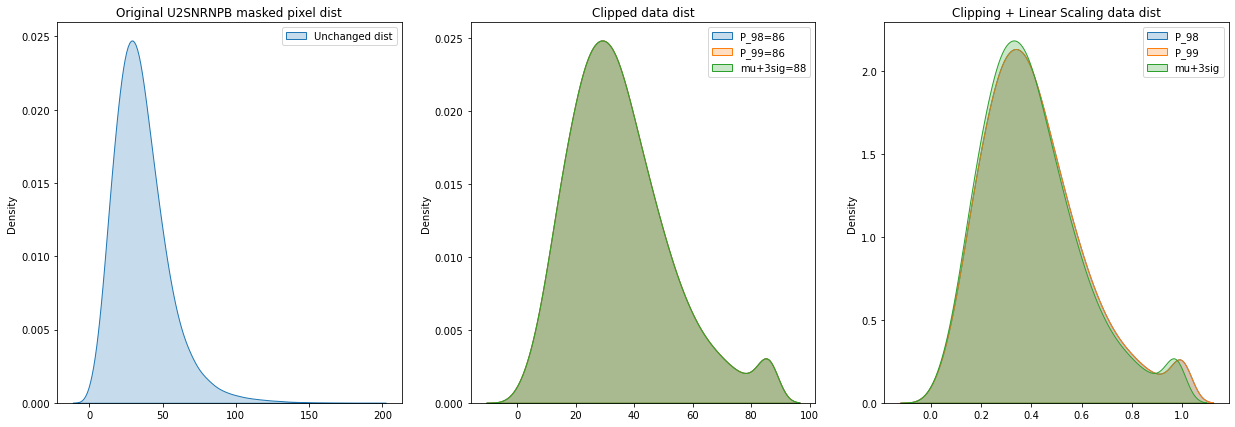

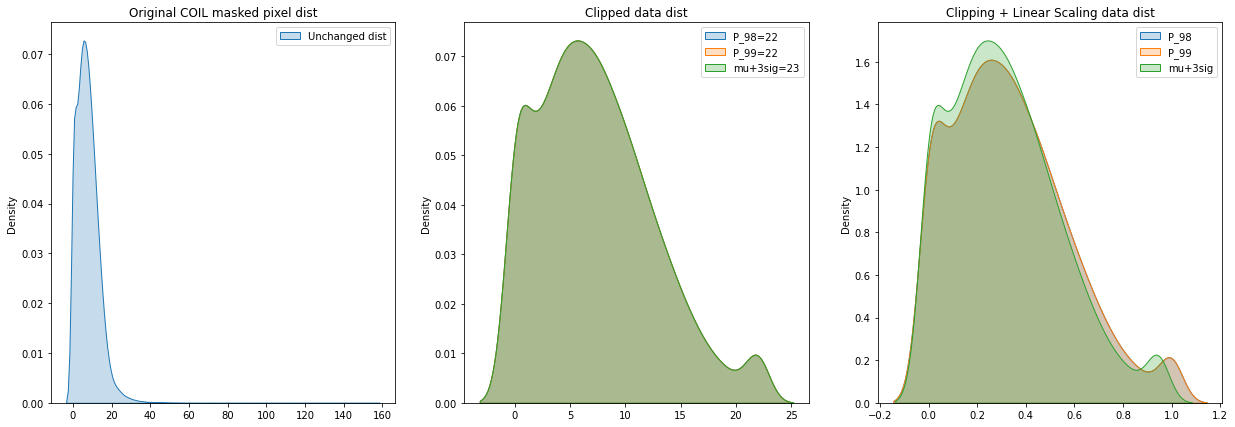

In [10]:
for i in range(n_jobs):
#for i in range(0,1):
    tic = time.time()
    with Pool(n_workers) as pool:
        results = [pool.apply_async(plot_orginial_channel_dist_vs_transform, p) for p in jobs[i]]

        print("Starting job ", i)
        for r in results:
            r.get()
    print('Job completed in {} mins'.format(round((time.time() - tic)/60)))
    del(jobs[i])
    del(pool)